## Sentiment Analysis of IMDB Movie Reviews

## Import Data

In [1]:
# Import libraries
import pandas as pd 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud 

#load data
df = pd.read_csv("IMDB Dataset.csv")

In [2]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# check null values in data
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [4]:
# check data distribution
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

No null values and the data is distributed equally so no class imbalance. Lets check word clouds for both positive and negative comments.

In [48]:
# Separate the positive and negative comments
positive_comments = df[df['sentiment'] == 'positive']['review'].str.cat(sep=' ')
negative_comments = df[df['sentiment'] == 'negative']['review'].str.cat(sep=' ')

In [50]:
# Generate word clouds
positive_wordcloud = WordCloud(width=1600, height=800, background_color='white', max_words=2000).generate(positive_comments)
negative_wordcloud = WordCloud(width=1600, height=800, background_color='black', colormap='Reds', max_words=2000).generate(negative_comments)

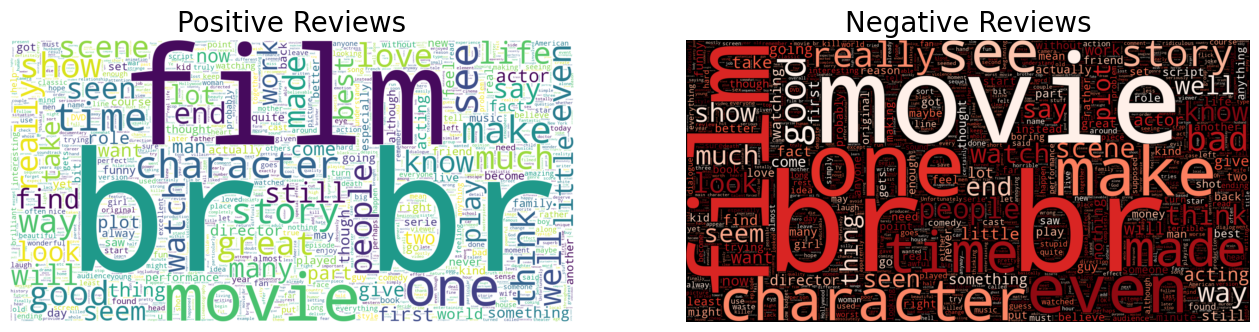

In [51]:
# Plot the word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Reviews', fontsize=20)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Reviews', fontsize=20)
plt.axis('off')

plt.show()

The reviews contain HTML tags which are repeating repeatedly in reviews which may hinder the model's performance so we will remove that during preprocessing.

## Data Preprocessing

In [5]:
# Import libraries
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

In [6]:
# download modules for text processing
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hassan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hassan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hassan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
def preprocess_text(review):
    # Convert to lowercase
    review = review.lower()

    # Remove HTML tags
    soup = BeautifulSoup(review, "html.parser")
    review = soup.get_text()
    
    # Remove special characters, numbers, and extra whitespace
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = re.sub(r'\s+', ' ', review).strip()

    # Remove URL's
    review = re.sub(r'https?://\S+|www\.\S+', '', review)
    
    # Tokenization
    tokens = word_tokenize(review)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [8]:
# Apply preprocessing
df['processed_review'] = df['review'].apply(preprocess_text)

C:\Users\Hassan\AppData\Local\Temp\ipykernel_15988\387629468.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(review, "html.parser")


In [57]:
df.head()

,review,sentiment,processed_review
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


In [58]:
# Separate the positive and negative comments
positive_comments = df[df['sentiment'] == 'positive']['processed_review'].str.cat(sep=' ')
negative_comments = df[df['sentiment'] == 'negative']['processed_review'].str.cat(sep=' ')

In [59]:
# Generate word clouds
positive_wordcloud = WordCloud(width=1600, height=800, background_color='white', max_words=2000).generate(positive_comments)
negative_wordcloud = WordCloud(width=1600, height=800, background_color='black', colormap='Reds', max_words=2000).generate(negative_comments)

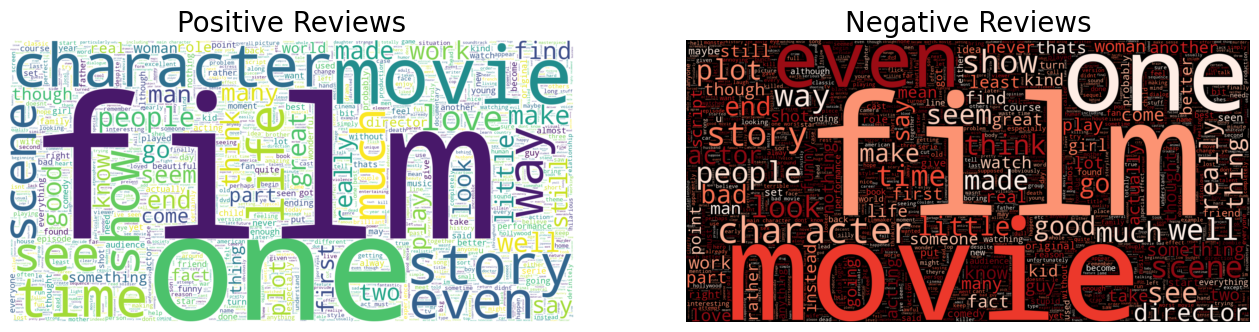

In [60]:
# Plot the word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Reviews', fontsize=20)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Reviews', fontsize=20)
plt.axis('off')

plt.show()

Much better now as the reviews are processed and cleaned effectively.

In [9]:
# Save preprocessed dataset to a csv file
df.to_csv("preprocessed_dataset.csv", index=False)

## Feature Engineering

Using Avg Word2Vec for transforming text to vectors since it preserves the sentiment meaning of the word (which will help in sentiment analysis).

In [31]:
# Import libraries
import numpy as np
from gensim.models import Word2Vec

C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\paramiko\transport.py:256: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [32]:
# Generate feature vectors for Word2Vec
def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float32")
        nwords = 0.
        for word in words:
            if word in vocabulary:
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)
        return feature_vector

In [33]:
# Function to apply Avg Word2Vec
def apply_avg_word2vec(texts, model):
    vocabulary = set(model.wv.index_to_key)
    features = [average_word_vectors(text.split(), model, vocabulary, model.vector_size) for text in texts]
    return pd.DataFrame(features)

In [34]:
# Train Word2Vec model on the cleaned texts
sentences = [text.split() for text in df['processed_review']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [35]:
# Apply average Word2Vec to the cleaned texts
word2vec_features = apply_avg_word2vec(df['processed_review'], word2vec_model)

In [36]:
# Rename columns of word2vec_features
word2vec_features.columns = [f'word2vec_feature_{i}' for i in range(word2vec_features.shape[1])]

In [37]:
word2vec_features

,word2vec_feature_0,word2vec_feature_1,word2vec_feature_2,word2vec_feature_3,word2vec_feature_4,word2vec_feature_5,word2vec_feature_6,word2vec_feature_7,word2vec_feature_8,word2vec_feature_9,...,word2vec_feature_90,word2vec_feature_91,word2vec_feature_92,word2vec_feature_93,word2vec_feature_94,word2vec_feature_95,word2vec_feature_96,word2vec_feature_97,word2vec_feature_98,word2vec_feature_99
0,-0.555466,0.727270,0.309126,0.145263,0.006857,-0.769716,-0.195929,0.573663,-0.471817,-0.686158,...,0.572546,-0.026766,-0.012132,0.021126,0.595618,0.245898,-0.045401,-0.536923,0.148896,-0.385902
1,-0.416824,0.821223,-0.337296,0.216313,0.157377,-0.371219,0.263205,0.875664,-0.446624,-0.618275,...,0.308091,0.015614,0.189589,0.085822,0.508978,0.086203,-0.038048,-0.358281,-0.334136,-0.348059
2,-0.122561,0.839414,-0.182396,0.432059,-0.048358,-0.133716,0.091598,0.741002,-0.668028,-0.734486,...,0.736650,-0.085852,0.067126,0.221456,0.837753,0.350666,-0.248835,-0.335992,0.339980,-0.607662
3,-0.343278,0.975596,-0.054660,0.558255,-0.032321,-0.723403,-0.162362,0.880716,-0.281321,-0.924087,...,0.702404,-0.181629,-0.331682,0.136023,0.618524,0.313061,-0.481244,-0.475224,0.113707,-0.488047
4,-0.248065,0.835862,-0.411877,0.081171,0.078976,-0.703110,-0.105911,0.974745,-0.258477,-0.722080,...,0.723668,0.014038,0.127644,-0.027630,0.766918,-0.045689,-0.139451,-0.501264,0.008633,-0.551637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.214800,0.798765,-0.248310,0.441173,-0.366667,-0.127383,-0.285776,0.682850,-0.260979,-1.110041,...,0.655405,-0.005702,-0.263442,0.167195,0.971373,0.499430,-0.550892,-0.201654,0.771489,-0.993215
49996,-0.318471,0.474937,-0.154566,0.375008,-0.546158,-0.280302,0.406478,0.363402,-0.150546,-0.768210,...,0.731327,-0.234494,-0.621425,-0.053464,0.503018,0.455067,-0.409527,-0.461310,0.685993,-0.466408
49997,-0.576423,0.635877,-0.189782,0.173771,0.238203,-0.902636,-0.297439,0.846424,-0.303314,-0.522008,...,0.781616,-0.097695,-0.007395,-0.006136,0.423303,0.389424,-0.187301,-0.558724,0.110100,-0.284248
49998,-0.203443,0.762722,-0.142871,0.279895,0.084703,-0.597570,0.020774,0.831851,-0.121759,-0.543778,...,0.531214,0.013294,-0.035914,0.203323,0.709327,0.211378,-0.113013,-0.433081,-0.083985,-0.270762


In [38]:
# Check shape of the features
word2vec_features.shape

(50000, 100)

In [39]:
# Encode the target variables
from sklearn.preprocessing import LabelEncoder

class_label_encoder = LabelEncoder()

df['sentiment_encoded'] = class_label_encoder.fit_transform(df['sentiment'])

In [40]:
df.head()

,review,sentiment,processed_review,sentiment_encoded
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...,1
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...,1
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,1
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...,1


In [41]:
## Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(word2vec_features,df['sentiment_encoded'],test_size=0.20)

## Model Fitting and Evaluation

Using SVM Classifier since it is well suited handle large feature spaces.

### SVM Classifier

In [42]:
# Import libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

svc = SVC()

In [43]:
# Fit model on training data
svc.fit(X_train,y_train)

SVC()

In [44]:
# make predictions on test data
y_pred=svc.predict(X_test)

In [46]:
# Evaluate model
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.8661
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      4995
           1       0.86      0.88      0.87      5005

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

